In [1]:
from copy import deepcopy

import graphviz
import numpy as np
import pydot
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils as kutils
from tensorflow.keras.layers import Concatenate

In [2]:
data = load_iris()
X = data["data"]
y = kutils.to_categorical(data["target"])

In [3]:
xtr, xts, ytr, yts = train_test_split(X, y, train_size=0.7, shuffle=True)

In [4]:
def make_classic_dense(layer_sizes):
    input, output = layer_sizes[0], layer_sizes[-1]
    model = keras.Sequential()
    model.add(layers.Dense(layer_sizes[1], input_dim=layer_sizes[0], activation="relu"))
    for size in layer_sizes[2:-1]:
        model.add(layers.Dense(size, activation="relu"))
    model.add(layers.Dense(layer_sizes[-1], activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


def plot_history(hist, sup_txt=""):
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))

    fig.suptitle(f"History {sup_txt}")

    ax_loss.plot(hist.history["loss"], label="train")
    ax_loss.plot(hist.history["val_loss"], label="test")
    ax_loss.grid()
    ax_loss.set_ylabel("Loss")
    ax_loss.set_xlabel("Epochs")
    ax_loss.legend()

    ax_acc.plot(np.array(hist.history["accuracy"]) * 100, label="train")
    ax_acc.plot(np.array(hist.history["val_accuracy"]) * 100, label="test")
    ax_acc.grid()
    ax_acc.set_ylabel("Accuracy [%]")
    ax_acc.set_xlabel("Epochs")
    ax_acc.legend()
    return fig, (ax_loss, ax_acc)

In [5]:
models = {
    "Dense[8]": make_classic_dense([4, 8, 3]),
    "Dense[8,8]": make_classic_dense([4, 8, 8, 3]),
    "Dense[8,16,8]": make_classic_dense([4, 8, 16, 8, 3]),
}
_ = [model.summary() for model in models.values()]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                

In [6]:
hists = {
    name: model.fit(
        xtr, ytr, validation_data=(xts, yts), epochs=25, batch_size=10, verbose=0
    )
    for name, model in models.items()
}

[<Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>,
 <Figure size 1200x400 with 2 Axes>]

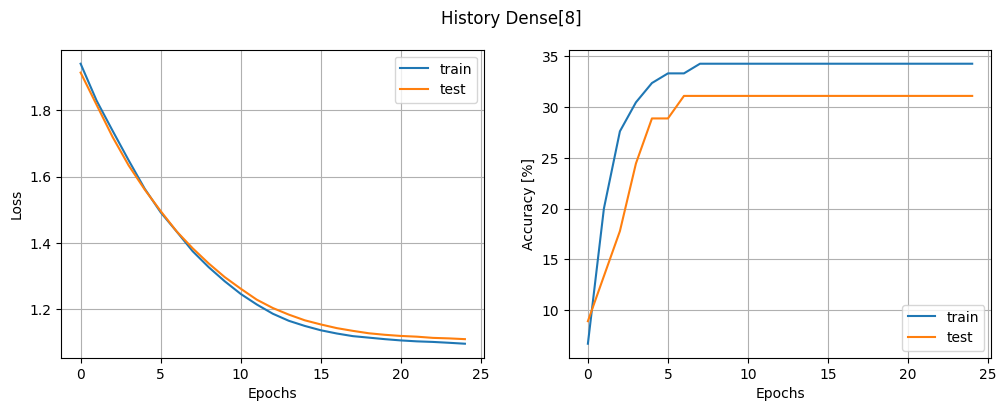

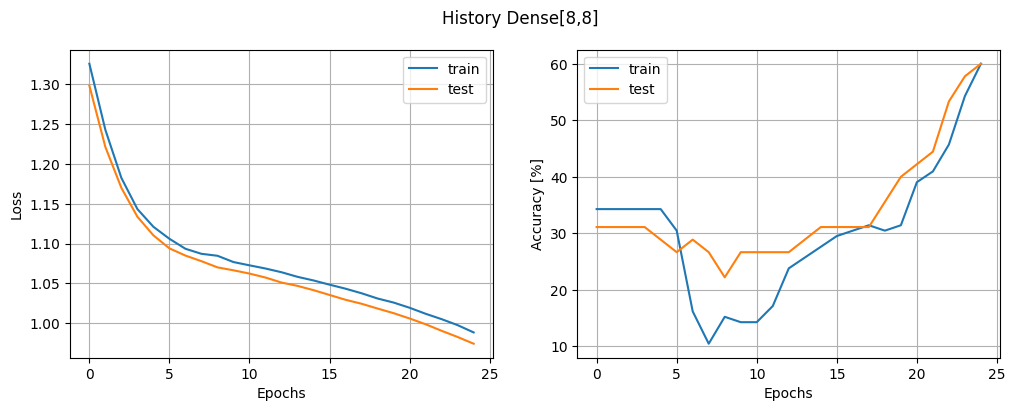

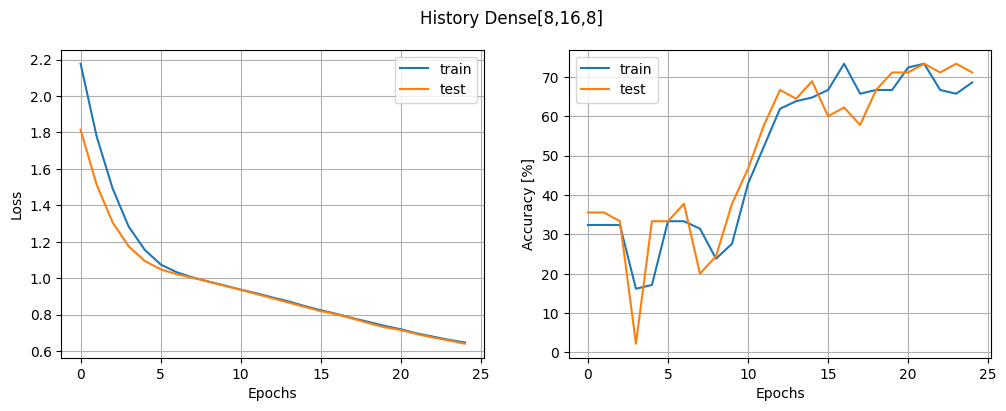

In [7]:
[plot_history(hist, name)[0] for name, hist in hists.items()]

In [8]:
[[name, model.evaluate(xts, yts, batch_size=10)] for name, model in models.items()]

5/5 [==============================] - 0s 1ms/step - loss: 0.6403 - accuracy: 0.7111


[['Dense[8]', [1.1102699041366577, 0.31111112236976624]],
 ['Dense[8,8]', [0.9743044376373291, 0.6000000238418579]],
 ['Dense[8,16,8]', [0.6403036117553711, 0.7111111283302307]]]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dense_5_input (InputLayer)  [(None, 4)]                  0         []                            
                                                                                                  
 dense_2_input (InputLayer)  [(None, 4)]                  0         []                            
                                                                                                  
 ensemble_3_dense_5 (Dense)  (None, 8)                    40        ['dense_5_input[0][0]']       
                                                                                                  
 dense_input (InputLayer)    [(None, 4)]                  0         []                            
                                                                                              

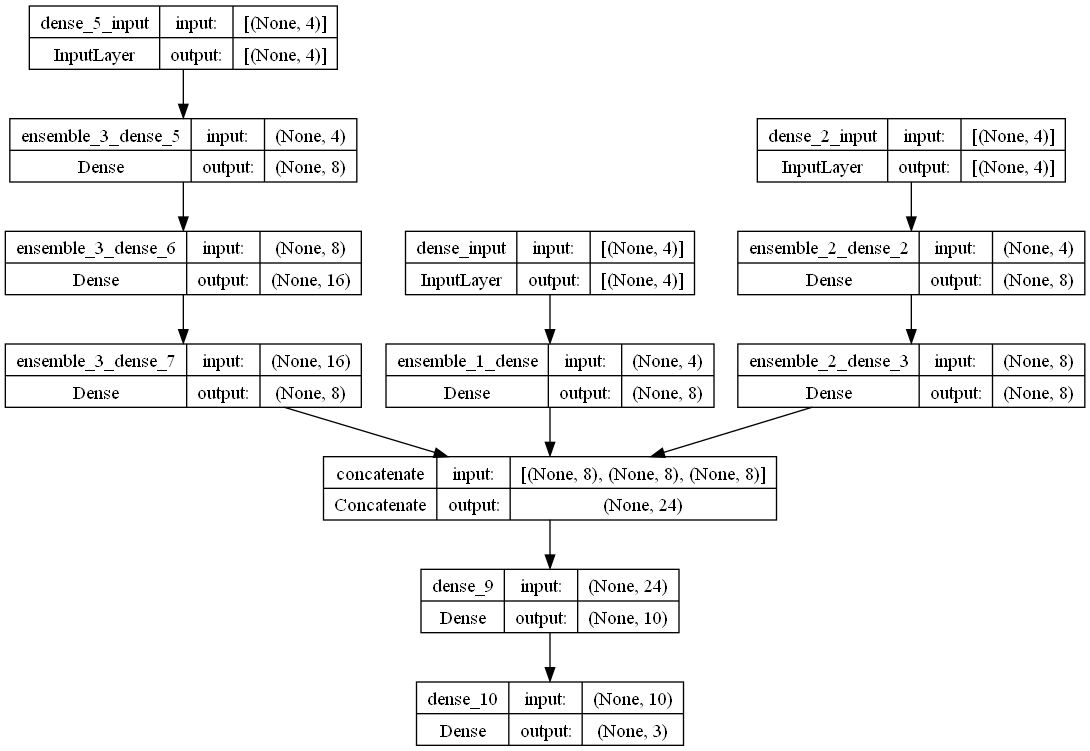

In [9]:
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.layers[-2].output for model in members]
    merge = Concatenate()(ensemble_outputs)
    hidden = layers.Dense(10, activation='relu')(merge)
    output = layers.Dense(3, activation='softmax')(hidden)
    model = keras.Model(inputs=ensemble_visible, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def stacked_fit(model, xtr, ytr, **kwargs):
    xtr_mul = [xtr for _ in range(len(model.input))]
    if 'validation_data' in kwargs:
        kwargs['validation_data'] = ([kwargs['validation_data'][0] for _ in range(len(model.input))], kwargs['validation_data'][1])
    return model.fit(xtr_mul, ytr, **kwargs)

def stacked_evaluate(model, xts, yts, **kwargs):
    xts_mul = [xts for _ in range(len(model.input))]
    return model.evaluate(xts_mul, yts, **kwargs)

stacked_model = define_stacked_model(list(models.values()))
stacked_model.summary()
stacked_fit(stacked_model, xtr, ytr, validation_data=(xts, yts), epochs=25, batch_size=10, verbose=0)
print(stacked_evaluate(stacked_model, xts, yts, batch_size=10))
kutils.plot_model(stacked_model, show_shapes=True)